In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')
print(AUDIO_DIR)

C:\Users\bisar\Desktop\IIT\Courses\Spring 2020\Deep Learning\FInal Project\Main Ref Docs\fma\test_audio_files


In [3]:
# Load metadata and features.
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
import copy
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [6]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
x_train = features.loc[small & train, 'mfcc']
x_test = features.loc[small & test, 'mfcc']

y_val = tracks.loc[small & val, ('track', 'genre_top')]
x_val = features.loc[small & val, 'mfcc']


print('{} training examples, {} testing examples'.format(y_train.shape, y_test.size))
print('{} val examples'.format(y_val.size))

print('{} features, {} classes'.format(x_train.shape, np.unique(y_train).size))

(6400,) training examples, 800 testing examples
800 val examples
(6400, 140) features, 8 classes


In [7]:
def one_hot_enc(y_data):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_data)
    print(integer_encoded.size)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#     print(onehot_encoded.shape)
    return onehot_encoded

In [8]:
print('{} training examples, {} testing examples'.format(y_train.shape, y_test.size))
print('{} val examples'.format(y_val.size))

print('{} features, {} classes'.format(x_train.shape, np.unique(y_train).size))

# Be sure training samples are shuffled.
x_train, y_train = skl.utils.shuffle(x_train, y_train, random_state=42)
x_val, y_val = skl.utils.shuffle(x_val, y_val, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(x_train)
scaler.transform(x_test)
scaler.transform(x_val)

y_train = one_hot_enc(y_train)
y_val = one_hot_enc(y_val)
y_test = one_hot_enc(y_test)

x_train = x_train.as_matrix()
x_val = x_val.as_matrix()
x_test = x_test.as_matrix()

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))



# # Support vector classification.
# clf = skl.svm.SVC()
# clf.fit(X_train, y_train)
# score = clf.score(X_test, y_test)
# print('Accuracy: {:.2%}'.format(score))

(6400,) training examples, 800 testing examples
800 val examples
(6400, 140) features, 8 classes
6400
800
800
51200 training examples, 6400 testing examples


c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10404222865258454989
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4828102656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6925796068850592330
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [11]:
def generate_model(input_shape):
    model = models.Sequential()
    # Hidden layers cannot be too small because if it is, then there will be information loss
    model.add(layers.Dense(512, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512, activation='relu'))

    model.add(layers.Dense(8, activation='softmax'))


    # Compile the model
    # Use sparse categorical cross entropy for loss if NOT using one hot encoding. Both give same results
    model.compile(
        optimizer=optimizers.Adam(lr=0.001,decay=0.1),
        loss='categorical_crossentropy', metrics=['acc'])
    return model

In [12]:
def plot_epocs_graph(history_dict, bin_acc=True):
    loss_vals = history_dict['loss']
    val_loss_vals = history_dict['val_loss']
    epochs = range(1, len(history_dict['binary_accuracy'] if bin_acc else history_dict['acc']) + 1)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_vals, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_vals, 'b', label='Validation Loss')
    plt.title("Training and validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc_vals = history_dict['binary_accuracy'] if bin_acc else history_dict['acc']
    val_acc_vals = history_dict['val_binary_accuracy'] if bin_acc else history_dict['val_acc']
    plt.plot(epochs, acc_vals, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc_vals, 'b', label='Validation accuracy')
    plt.title("Training and validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig("../doc/graphs/val_loss_acc_epochs_task1.png")
    plt.show()
    return

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 6400 samples, validate on 800 samples
Epoch 1/12
6400/6400 [==============================] - 1s 91us/sample - loss: 1.9004 - acc: 0.3123 - val_loss: 1.7975 - val_acc: 0.3525
Epoch 2/12
6400/6400 [==============================] - 0s 10us/sample - loss: 1.6279 - acc: 0.4123 - val_loss: 1.7839 - val_acc: 0.4212
Epoch 3/12
6400/6400 [==============================] - 0s 10us/sample - loss: 1.5855 - acc: 0.4283 - val_loss: 1.7453 - val_acc: 0.4550
Epoch 4/12
6400/6400 [==============================] - 0s 13us/sample - loss: 1.5369 - acc: 0.4450 - val_loss: 1.7169 - val_acc: 0.4762
Epoch 5/12
6400/6400 [==============================] - 0s 10us/sample - loss: 1.5124 - acc: 0.4578 - val_loss: 1.6866 - val_acc: 0.5025
Epoch 6/12
6400/6400 [==============================] - 0s 10us/sample - loss: 1.4853 - acc: 0.4598 - val_loss: 1.6566 - val_acc: 0.5100
Epoch 7/12
6400/6400 [============================

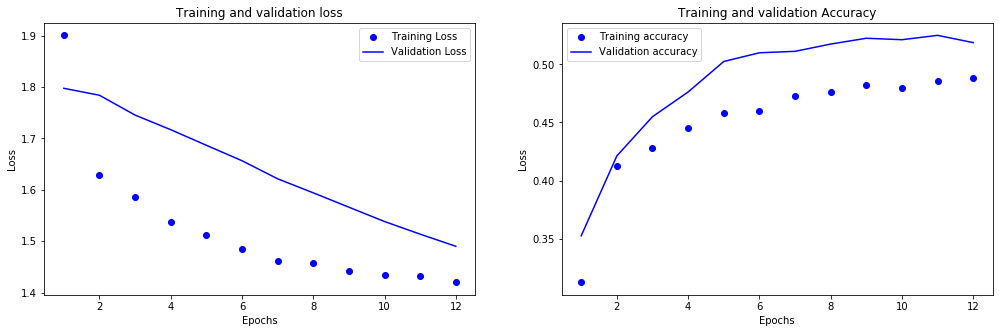

800/800 [==============================] - 0s 65us/sample - loss: 1.6485 - acc: 0.4150

 Test Accuracy 41.49999916553497


In [13]:

def build_train_validate(x_train, y_train, input_shape, x_val, y_val):
    # Build the network
    model = generate_model(input_shape)

#     # Training and validation
    history = model.fit(x_train, y_train, nb_epoch=12, batch_size=512, validation_data=(x_val, y_val))
    history_dict = history.history
    print(history_dict.keys())
    print(f'avg accuracy {np.mean(history_dict["acc"])}')
    print(f'val avg accuracy {np.mean(history_dict["val_acc"])}')
    plot_epocs_graph(history_dict, False)
    results = model.evaluate(x_test, y_test)
    print(f'\n Test Accuracy {results[1]*100}')
    return model

build_train_validate(x_train, y_train, x_train.shape[1:], x_val, y_val)